In [1]:
import os
import re
import glob 
import tables
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt

In [8]:
gbfisher_columns = ['f','colatitude','longitude','amplitude','inclination','polarization','phase','fdot','fddot','sigma_df/f','sigma_colatitude','sigma_longitude','sigma_dA/A','sigma_inclination','sigma_polarization','sigma_phase','sigma_dfdot/fdot','sigma_dfddot/fddot','sigma_Omega','SNR','b','l','mchirp','distance'] 
gbfisher = pd.read_table('../ldasoft/gbfisher_example/gbfisher_parameters.dat',delimiter=' ', header=None,index_col=False,names=gbfisher_columns)
gbfisher['inclination'] = 90 - abs(np.degrees(gbfisher['inclination']) - 90)
# This makes plots readable, remove this part once better binaries are established
for i, v in enumerate(gbfisher['sigma_inclination']):
    vd = 90 - abs(np.degrees(v) - 90)
    if(90 - gbfisher['inclination'].iloc[i] < vd or gbfisher['inclination'].iloc[i] < vd):
        gbfisher['sigma_inclination'].iloc[i] = min(90 - gbfisher['inclination'].iloc[i],gbfisher['inclination'].iloc[i]) 
    else:
        gbfisher['sigma_inclination'].iloc[i] = 90 - abs(np.degrees(gbfisher['sigma_inclination'].iloc[i]) - 90)
    
gbfisher.head()

,f,colatitude,longitude,amplitude,inclination,polarization,phase,fdot,fddot,sigma_df/f,...,sigma_polarization,sigma_phase,sigma_dfdot/fdot,sigma_dfddot/fddot,sigma_Omega,SNR,b,l,mchirp,distance
0,0.000167,0.954373,3.95410,1.161330e-21,33.484971,2.811940,4.502780,3.934090e-21,3.402775e-37,1.146358e-09,...,4.038658,8.090218,2319.0080,-2.038056e+35,387.10050,7.325647,50.753900,26.979350,0.647315,74.887180
1,0.000228,2.314790,5.13768,2.022570e-21,32.567646,0.387113,5.684570,2.339130e-20,8.783644e-36,3.864640e-10,...,1.465059,2.931015,122.3382,-2.346923e+76,34.10879,23.505228,-36.862214,333.292859,0.944428,99.525353
2,0.000239,1.378990,3.70650,7.084380e-22,42.355504,1.010720,4.368750,9.419650e-21,1.358484e-36,1.004055e-09,...,1.317386,2.650650,835.3373,-1.073716e+87,289.39830,8.478600,54.522490,341.206947,0.493036,99.259633
3,0.000258,0.435550,4.37646,7.339190e-22,33.104928,0.711186,2.723050,1.427740e-20,2.900895e-36,8.342095e-10,...,3.156211,6.304739,462.8349,-1.417575e+117,135.05950,10.173851,34.856260,67.346022,0.538759,116.623744
4,0.000260,1.051890,2.77283,3.967470e-22,5.038170,3.067500,0.408942,1.993050e-20,5.601841e-36,1.260179e-09,...,8254.941000,16509.850000,494.2016,-1.218546e+137,382.60540,7.214529,71.669891,181.334502,0.645133,293.070870


In [3]:
gwemlisa_columns = ['B_n','O_n','q','+s_q','-s_q','i','+s_i','-s_i']
binDir = os.path.join(os.getcwd(),'out-gwprior')
exclude = ['fdot','inc']
data = []

for binary in os.listdir(binDir):
    for foldername in os.listdir(os.path.join(binDir,binary)):
        if os.path.isdir(os.path.join(binDir,os.path.join(binary,foldername))) & (not foldername in exclude):
            q = []
            i = []
            B_n = int(re.search('binary(.+?)row',foldername).group(1))
            O_n = int(re.search('row(.+?)_incl',foldername).group(1))
            binPath = os.path.join(foldername,'post_equal_weights.dat')
            raw = open(os.path.join(binDir,os.path.join(binary,binPath)),'r')
            for pos, line in enumerate(raw):
                values = [float(i) for i in line.split()]
                q.append(values[2])
                i.append(90 - abs(values[4] - 90))
            raw.close()
            q_50, q_10, q_90 = np.percentile(q,50), np.percentile(q,10), np.percentile(q,90)
            i_50, i_10, i_90 = np.percentile(i,50), np.percentile(i,10), np.percentile(i,90)
            data.append([B_n, O_n, q_50, q_90-q_50, q_50-q_10, i_50, i_90-i_50, i_50-i_10])
gwemlisa = pd.DataFrame(data,columns=gwemlisa_columns)
gwemlisa = gwemlisa.sort_values(['B_n','O_n']).reset_index(drop=True)
gwemlisa.head()

,B_n,O_n,q,+s_q,-s_q,i,+s_i,-s_i
0,1,0,0.746720,0.193228,0.186958,24.834075,24.865567,21.429897
1,1,1,0.710342,0.205680,0.167112,22.339112,27.340328,19.674389
2,1,2,0.760506,0.193134,0.209425,19.771666,30.555164,16.680519
3,1,3,0.742162,0.196697,0.192755,20.619561,29.135329,17.663411
4,1,4,0.740008,0.183288,0.196065,18.809551,30.682731,16.698727


In [4]:
igwemlisa_columns = ['i','+s_i','-s_i']
data = []
i = []
i_p = []
i_m = []
for j in range(gwemlisa.shape[0]):
    i.append(gwemlisa['i'][j])
    i_p.append(gwemlisa['+s_i'][j])
    i_m.append(gwemlisa['-s_i'][j])
    if(gwemlisa['O_n'][j] == gwemlisa['O_n'].max()):
        i_50, i_10, i_90 = np.percentile(i,50), np.percentile(i_m,50), np.percentile(i_p,50)
        data.append([i_50, i_90, i_10])
        i = []
        i_p = []
        i_m = []
igwemlisa = pd.DataFrame(data,columns=igwemlisa_columns)

In [5]:
qgwemlisa_columns = ['q','+s_q','-s_q']
data = []
q = []
q_p = []
q_m = []
for j in range(gwemlisa.shape[0]):
    q.append(gwemlisa['q'][j])
    q_p.append(gwemlisa['+s_q'][j])
    q_m.append(gwemlisa['-s_q'][j])
    if(gwemlisa['O_n'][j] == gwemlisa['O_n'].max()):
        q_50, q_10, q_90 = np.percentile(q,50), np.percentile(q_m,50), np.percentile(q_p,50)
        data.append([q_50, q_90, q_10])
        q = []
        q_p = []
        q_m = []
qgwemlisa = pd.DataFrame(data,columns=qgwemlisa_columns)

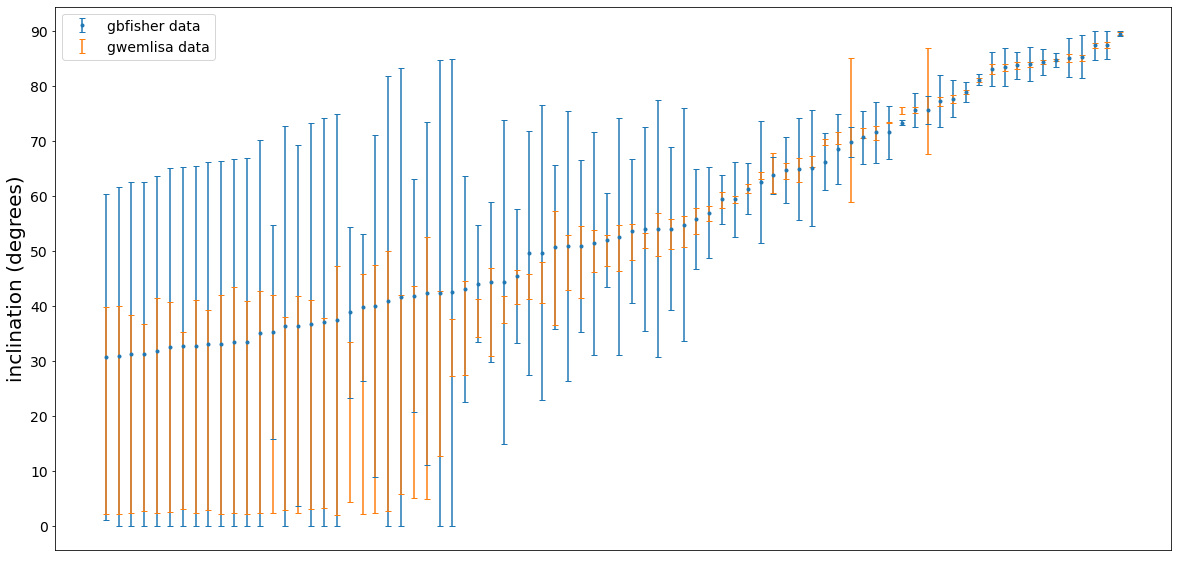

In [6]:
i_gbfisher = gbfisher.sort_values(['inclination']).reset_index()
i_gwemlisa = igwemlisa.sort_values(['i']).reset_index()

# This adjusts the interval of binaries which are shown
lb = 20
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xticks([])
plt.yticks(np.arange(0, 100, 10))
plt.errorbar(x=range(lb,ub),y=i_gbfisher['inclination'][cut],capsize=3,yerr=i_gbfisher['sigma_inclination'][cut],linestyle='',marker='.')
plt.errorbar(x=range(lb,ub),y=i_gwemlisa['i'][cut],capsize=3,yerr=np.transpose(np.array(i_gwemlisa[['-s_i','+s_i']][cut])),linestyle='',marker='')
plt.ylabel('inclination (degrees)',fontsize=20)
ax.legend(['gbfisher data','gwemlisa data'],fontsize=14)
# fig.savefig('inclination_plot.jpg')

Text(0, 0.5, 'mass ratio')

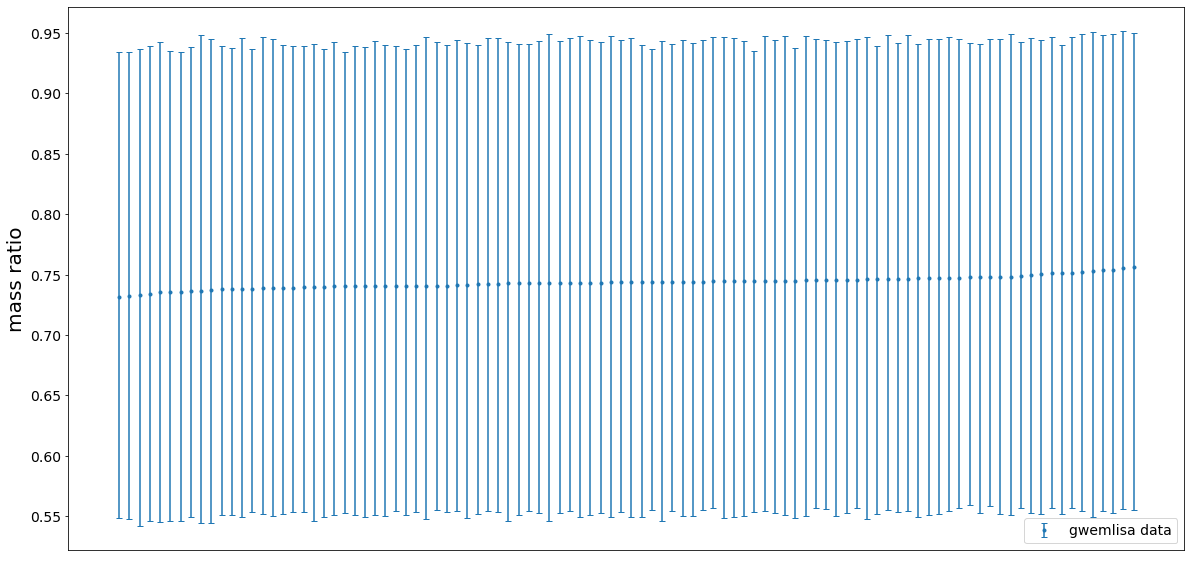

In [7]:
q_gwemlisa = qgwemlisa.sort_values(['q']).reset_index()

# This adjusts the interval of binaries which are shown
lb = 0
ub = 100
cut = [False]*lb + [True]*(ub-lb) + [False]*(100-ub)

fig, ax = plt.subplots(figsize=(20,10))
ax.tick_params(axis="y", labelsize=14)
plt.xticks([])
plt.errorbar(x=range(lb,ub),y=q_gwemlisa['q'][cut],capsize=3,yerr=np.transpose(np.array(q_gwemlisa[['-s_q','+s_q']][cut])),linestyle='',marker='.')
ax.legend(['gwemlisa data'],fontsize=14)
plt.ylabel('mass ratio',fontsize=20)
# fig.savefig('mass_ratio_plot.jpg')